In [ ]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/data/main/RNNDATA.csv')
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [ ]:
import tqdm
import torch
from torch.optim.adam import Adam

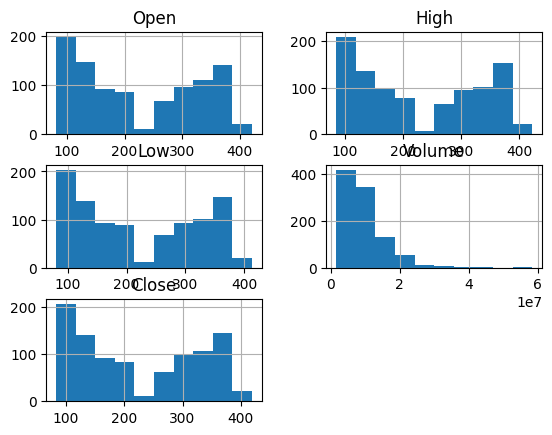

In [ ]:
# 데이터 분포 확인
import matplotlib.pyplot as plt
data.hist()
plt.show()

In [ ]:
# Open, High, Low 는 x, close는 y, volume은 사용 안함
import numpy as np

In [ ]:
csv = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/data/main/RNNDATA.csv')
csv[0:30]

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116
5,2015-12-23,117,119,116,9324300,118
6,2015-12-24,118,119,117,3531300,117
7,2015-12-28,117,117,114,8424300,117
8,2015-12-29,118,120,117,8159200,119
9,2015-12-30,119,119,116,8149700,117


In [ ]:
# 데이터셋
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self) -> None:
        self.csv = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/data/main/RNNDATA.csv')
        self.data = self.csv.iloc[:, 1:-2].values
        self.data = self.data / np.max(self.data)

        self.label = self.csv.iloc[:, -1].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30  # 사용 가능한 배치

    def __getitem__(self, index):
        data = self.data[index:index+30]
        label = self.label[index+30]
        return data, label


In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        # 시계열 특징 추출
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        # (batch_size, 30, 3) 입력이 8개로 변환됨 (batch_size, 30, 8)

        # MLP 층 정의 (분류기)
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)  # x는 마지막 RNN 층의 출력, hn은 모든 RNN 층의 은닉 상태
        x = torch.reshape(x, (x.shape[0], -1))   # MLP 층에 사용하기 위해 모양 변경

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = torch.flatten(x)

        return x

In [ ]:
from torch.utils.data.dataloader import DataLoader
dataset = Netflix()     # 데이터 셋
loader = DataLoader(dataset, batch_size=32)

In [ ]:
# 학습
import tqdm
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else 'cpu'
model = RNN().to(device)
optim = Adam(model.parameters(), lr = 1e-4)

In [ ]:
# 학습
iterator = tqdm.tqdm(range(200))
for epoch in iterator:
  for data, label in loader:
    optim.zero_grad()
    # 초기 은닉상태  (은닉층개수, 배치크기, 출력차원) -->0
    h0 = torch.zeros(5,data.shape[0],8).to(device)
    # 모델 forward - 예측
    pred = model(data.type(torch.FloatTensor).to(device), h0)
    # 손실
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device) )
    # 역전파
    loss.backward()
    # 가중치 업데이트(최적화)
    optim.step()
    iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

epoch200 loss:0.0003381613933015615: 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


In [ ]:
# 평가
import matplotlib.pyplot as plt
# 평가용데이터 로더
loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
  for data, label in loader:
    # 초기 은닉상태  (은닉층개수, 배치크기, 출력차원) -->0
    h0 = torch.zeros(5,data.shape[0],8).to(device)
    pred = model(data.type(torch.FloatTensor).to(device), h0)
    preds.append(pred.item())

    loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
    total_loss += loss/len(loader)

In [ ]:
total_loss.item()

0.0013246111338958144

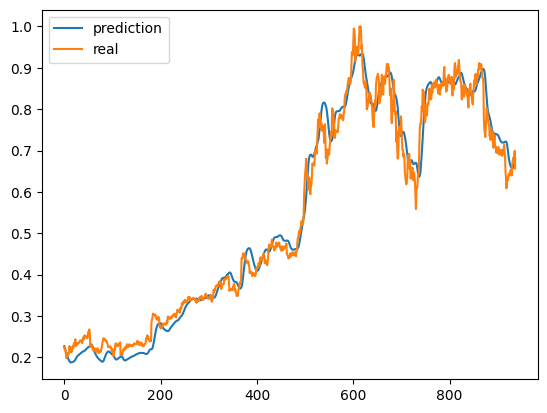

In [ ]:
plt.plot(preds,label="prediction")
plt.plot(dataset.label[30:],label="real")
plt.legend()
plt.show()

응용 LOTTO

In [1]:
!pip install xlrd

In [2]:
import pandas as pd
import numpy as np

In [4]:
lotto_df = pd.read_csv('/content/excel.csv')
lotto_df = lotto_df.loc[2:,'Unnamed: 13': 'Unnamed: 18']
lotto_df.columns = list(range(1,7))
lotto_df = lotto_df.reset_index(drop=True)
lotto_df.head(6)

,1,2,3,4,5,6
0,15,16.0,17.0,25.0,30.0,31.0
1,7,12.0,23.0,32.0,34.0,36.0
2,10,16.0,19.0,32.0,33.0,38.0
3,11,13.0,20.0,21.0,32.0,44.0
4,16,20.0,26.0,36.0,42.0,44.0
5,3,13.0,30.0,33.0,43.0,45.0


In [5]:
len(lotto_df)

1116

In [6]:
X = []
y = []
data = lotto_df.values
window_size = 5
for i in range(len(data)-window_size):
  X.append(data[i : i + window_size ])
  y.append(data[i+window_size])
X = np.array(X)
y = np.array(y)

In [7]:
X.shape

(1111, 5, 6)

In [8]:
# 하이퍼 파라메터
input_size = X.shape[-1]
hidden_size = 64
num_layers = 5
output_size = input_size
epochs = 100
lr = 1e-4

In [9]:
# 데이터셋
from torch.utils.data.dataset import Dataset
import numpy as np

class LottoDataset(Dataset):
  def __init__(self):
    lotto_df = pd.read_csv('/content/excel.csv')
    lotto_df = lotto_df.loc[2:,'Unnamed: 13': 'Unnamed: 18']
    lotto_df.columns = list(range(1,7))
    lotto_df = lotto_df.reset_index(drop=True)
    self.data = lotto_df.applymap(lambda x: float(x)).values

  def __len__(self):
    return len(self.data) - 5 # 사용가능한 배치

  def __getitem__(self, index):
    data = self.data[index: index+5]
    label = self.data[index+5]
    return data, label

In [11]:
from torch.utils.data import DataLoader

lottodataset = LottoDataset()
data,label = next(iter(lottodataset))
print(data)
loader = DataLoader(lottodataset, batch_size=32)
data, label =  next(iter(loader))
data.shape, label.shape

[[15. 16. 17. 25. 30. 31.]
 [ 7. 12. 23. 32. 34. 36.]
 [10. 16. 19. 32. 33. 38.]
 [11. 13. 20. 21. 32. 44.]
 [16. 20. 26. 36. 42. 44.]]


(torch.Size([32, 5, 6]), torch.Size([32, 6]))

In [12]:
import torch.nn as nn
import torch
class LOTTO(nn.Module):
  def __init__(self):
    super(LOTTO,self).__init__()
    # 시계열 특징 추출
    self.rnn = nn.RNN(input_size = input_size,hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True)
     # (batch_size, 5,6) --> (batch_size, 5,64)

    # MLP 층 정의(분류기)  5*64 = 320
    self.fc1 = nn.Linear(in_features=5*64,out_features=64)
    self.fc2 = nn.Linear(in_features=64,out_features=6)
    self.relu = nn.ReLU()

  def forward(self,x, h):
    x, hn = self.rnn(x,h)  # x 마지막RNN층의 은닉상태, hn 모든 RNN층의 은닉상태
    x = torch.reshape(x, (x.shape[0],-1))  # mlp층에 사용하기 위해서 모양 변경

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    # x = torch.flatten(x)

    return x

In [13]:
# 학습
import tqdm
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else 'cpu'
model = LOTTO().to(device)
optim = Adam(model.parameters(),lr=1e-4)

iterator = tqdm.tqdm(range(200))
for epoch in iterator:
  for data, label in loader:
    optim.zero_grad()
    # 초기 은닉상태  (은닉층개수, 배치크기, 출력차원) -->0
    h0 = torch.zeros(5,data.shape[0],64).to(device)
    # 모델 forward - 예측
    pred = model(data.type(torch.FloatTensor).to(device), h0)
    # 손실
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device) )
    # 역전파
    loss.backward()
    # 가중치 업데이트(최적화)
    optim.step()
    iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

epoch200 loss:44.22526168823242: 100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


In [14]:
# 평가
import matplotlib.pyplot as plt
# 평가용데이터 로더
loader = DataLoader(lottodataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
  for data, label in loader:
    # 초기 은닉상태  (은닉층개수, 배치크기, 출력차원) -->0
    h0 = torch.zeros(5,data.shape[0],64).to(device)
    pred = model(data.type(torch.FloatTensor).to(device), h0)
    preds.append(pred[0])

    loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
    total_loss += loss/len(loader)
total_loss.item()

41.452728271484375

In [15]:
data, label = next(iter(loader))
data, label

(tensor([[[15., 16., 17., 25., 30., 31.],
          [ 7., 12., 23., 32., 34., 36.],
          [10., 16., 19., 32., 33., 38.],
          [11., 13., 20., 21., 32., 44.],
          [16., 20., 26., 36., 42., 44.]]], dtype=torch.float64),
 tensor([[ 3., 13., 30., 33., 43., 45.]], dtype=torch.float64))

In [16]:
h0 = torch.zeros(5,data.shape[0],64).to(device)
model(data.type(torch.FloatTensor).to(device), h0)

tensor([[ 6.5012, 12.8245, 19.7083, 25.8667, 32.6330, 38.9617]],
       grad_fn=<AddmmBackward0>)